# Models

## Preparations

### Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install keras_tuner

In [ ]:
!pip3 install beautifultable

### Modules import

In [ ]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from beautifultable import BeautifulTable

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, GaussianDropout
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from keras_tuner import Hyperband

### Constants

In [ ]:
class Paths:
  PROJECT_PATH = None # to fill
  
  RR_PEAKS_DATA_PATH = os.path.join(PROJECT_PATH, 'rr_peaks_eda.csv')
  SLIDING_WINDOW_1ST_DATA_PATH = os.path.join(PROJECT_PATH, 'sliding_window_1000_500_eda.csv')
  SLIDING_WINDOW_2ND_DATA_PATH = os.path.join(PROJECT_PATH, 'sliding_window_2000_300_eda.csv')
  SLIDING_WINDOW_3RD_DATA_PATH = os.path.join(PROJECT_PATH, 'sliding_window_2500_400_eda.csv')

class Labels:
  class Dataset:
    TARGETS_LABEL = 'affective_state'
    MAXS_LABEL = 0
    MEANS_LABEL = 1
    MINS_LABEL = 2

  class Visualization:
    MAX_LABEL = 'max'
    MEAN_LABEL = 'mean'
    MIN_LABEL = 'min'
    TRIAL_LABEL = 'trial'
    SPLIT_LABEL = 'split'
    PARAM_LABEL = 'param'
    METRICS_LABEL = 'metrics'

    AFFECTIVE_STATES_LABELS = ['HVHA', 'HVLA', 'LVLA', 'LVHA']

    TRAINING_LABEL = 'training'
    VALIDATION_LABEL = 'validation'

  class Results:
    TRAIN_ACCURACY_LABEL = 'train_accuracy'
    TEST_ACCURACY_LABEL = 'test_accuracy'
    F1_SCORE_LABEL = 'f1'
    PRECISION_LABEL = 'precision'
    RECALL_LABEL = 'recall'
    CROSS_VALIDATION_LABEL = 'cross validation'

    BEST_PARAMS_LABEL = 'best_params'
    CONFUSION_MATRIX_LABEL = 'confusion_matrix'
    HISTORY_LABEL = 'history'

    PRINTABLE_METRICS_LABELS = [
      TRAIN_ACCURACY_LABEL,
      TEST_ACCURACY_LABEL,
      F1_SCORE_LABEL,
      PRECISION_LABEL,
      RECALL_LABEL,
    ]

class Models:
  KFOLD_SPLITS = 5
  NEURAL_NETWORK_MODEL = tf.keras.models.Model

  class NonLinearSVM:
    NAME = 'Non linear SVM'
    INSTANCE = SVC()

    DEFAULT_PARAMS = {
        'kernel' : ['poly', 'sigmoid'],
        'gamma' : ['scale', 0.2, 15.0]
    }

  class LogisticRegression:
    NAME = 'Logistic Regression'
    INSTANCE = LogisticRegression(solver='liblinear', max_iter=10000)

    DEFAULT_PARAMS = {
      'C': [0.01, 0.1, 1],
      'penalty': ['l1', 'l2'],
      'tol': [1e-4, 5e-4, 1e-5]
    }

  class RandomForest:
    NAME = 'Random Forest'
    INSTANCE = RandomForestClassifier()

    DEFAULT_PARAMS = {
        'criterion' : ['gini', 'entropy'],
        'min_samples_leaf': [0.5, 0.3]
    }

  class LinearSVM:
    NAME = 'Linear SVM'
    INSTANCE = LinearSVC(dual=False, max_iter=10000)

    DEFAULT_PARAMS = {
      'intercept_scaling': np.linspace(0.01, 10, 51),
      'C': np.linspace(0.001, 0.01, 51),
      'penalty': ['l1', 'l2']
    }

  class DecisionTree:
    NAME = "Decision Tree"
    INSTANCE = DecisionTreeClassifier()

    DEFAULT_PARAMS = {
        'criterion' : ['gini', 'entropy'],
        'min_samples_split' : np.linspace(0.01, 0.1, 10),
        'min_samples_leaf': np.linspace(0.01, 0.1, 10)
    }

  class KNearestNeighbors:
    NAME = 'k Nearest Neighbors'
    INSTANCE = KNeighborsClassifier()

    DEFAULT_PARAMS = {
        'n_neighbors': [5, 50, 100],
        'algorithm':  ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2]
    }

  class NeuralNetwork:
    NAME = 'Neural Network'
    INSTANCE = Sequential()
    DEFAULT_PARAMS = {}

    EPOCHS_NUMBER = 100
    CLASSES_NUMBER = 4
    FEATURES_NUMBER = 13
    VERBOSE = 0
    VALIDATION_SPLIT = 0.2
    BATCH_SIZE = 8

    UNITS_MIN = 16
    UNITS_MAX = 32
    UNITS_STEP = 4

    TRAIN_METRICS = ['accuracy']
    HISTORY_METRICS = ['accuracy', 'loss']

    UNITS1_NAME = 'units1'
    UNITS2_NAME = 'units2'
    UNITS3_NAME = 'units3'

    ACTIVATION1_NAME = 'activation1'
    ACTIVATION2_NAME = 'activation2'
    ACTIVATION3_NAME = 'activation3'

    OPTIMIZER_NAME = 'optimizer'
    LOSS_NAME = 'loss'

    ACTIVATIONS = ['relu', 'selu']
    OPTIMIZERS = ['adam', 'adagrad', 'sgd']
    LOSSES = ['kl_divergence', 'poisson', 'categorical_crossentropy']

class TunerParams:
  DIRECTORY_NAME = 'my_tuner'
  MONITOR = 'loss'
  OBJECTIVE = 'accuracy'

  PARAMS_TO_REMOVE = [
    'tuner/trial_id',
    'tuner/epochs',
    'tuner/initial_epoch',
    'tuner/bracket',
    'tuner/round'
  ]

  EPOCHS_NUMBER = 100
  PATIENCE = 5
  VERBOSE = 0
  VALIDATION_SPLIT = 0.2

### Functions

In [ ]:
def load_signals_from_csv(path):
  return pd.read_csv(path)

def factorize_labels_in_dataframe(df):
  df[[Labels.Dataset.TARGETS_LABEL]] = pd.factorize(df[Labels.Dataset.TARGETS_LABEL])[0]
  return df

def convert_string_signal_to_array(row):
  row_cp = deepcopy(row)
  row_cp[Labels.Dataset.MAXS_LABEL] = np.fromstring(row[Labels.Dataset.MAXS_LABEL][1:-2], sep=',').mean()
  row_cp[Labels.Dataset.MEANS_LABEL] = np.fromstring(row[Labels.Dataset.MEANS_LABEL][1:-2], sep=',').mean()
  row_cp[Labels.Dataset.MINS_LABEL] = np.fromstring(row[Labels.Dataset.MINS_LABEL][1:-2], sep=',').mean()

  return row_cp

def get_train_and_test_split(data, test_size=0.2, shuffle_random_state=None, split_random_state=None):
  scaler = MinMaxScaler()

  features = data.columns[2:-1]
  targets = data.columns[-1]

  raw_X = data[features].to_numpy()
  y = data[targets].to_numpy()
  X = np.asarray(list(map(convert_string_signal_to_array, raw_X)))

  X, y = shuffle(X, y, random_state=shuffle_random_state)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=split_random_state)
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  return X_train, X_test, y_train, y_test

def build_model(hp):
  model = Sequential()

  hp_units1 = hp.Int(Models.NeuralNetwork.UNITS1_NAME, Models.NeuralNetwork.UNITS_MIN, Models.NeuralNetwork.UNITS_MAX, step=Models.NeuralNetwork.UNITS_STEP)
  hp_units2 = hp.Int(Models.NeuralNetwork.UNITS2_NAME, Models.NeuralNetwork.UNITS_MIN, Models.NeuralNetwork.UNITS_MAX, step=Models.NeuralNetwork.UNITS_STEP)
  hp_units3 = hp.Int(Models.NeuralNetwork.UNITS3_NAME, Models.NeuralNetwork.UNITS_MIN, Models.NeuralNetwork.UNITS_MAX, step=Models.NeuralNetwork.UNITS_STEP)

  hp_activation1 = hp.Choice(Models.NeuralNetwork.ACTIVATION1_NAME, values=Models.NeuralNetwork.ACTIVATIONS)
  hp_activation2 = hp.Choice(Models.NeuralNetwork.ACTIVATION2_NAME, values=Models.NeuralNetwork.ACTIVATIONS)
  hp_activation3 = hp.Choice(Models.NeuralNetwork.ACTIVATION3_NAME, values=Models.NeuralNetwork.ACTIVATIONS)

  hp_optimizer = hp.Choice(Models.NeuralNetwork.OPTIMIZER_NAME, values=Models.NeuralNetwork.OPTIMIZERS)

  hp_loss = hp.Choice(Models.NeuralNetwork.LOSS_NAME, values=Models.NeuralNetwork.LOSSES)

  model.add(Dense(hp_units1, input_dim=Models.NeuralNetwork.FEATURES_NUMBER, activation=hp_activation1))
  model.add(Dense(hp_units2, activation=hp_activation2))
  model.add(Dense(hp_units3, activation=hp_activation3))
  model.add(Dense(Models.NeuralNetwork.CLASSES_NUMBER, activation=softmax))
  model.compile(loss=hp_loss, optimizer=hp_optimizer, metrics=Models.NeuralNetwork.TRAIN_METRICS)

  return model

def find_model_best_hps(X, y):
  !rm -r my_tuner
  early_stopping = EarlyStopping(monitor=TunerParams.MONITOR, patience=TunerParams.PATIENCE)
  tuner = Hyperband(build_model, objective=TunerParams.OBJECTIVE, max_epochs=TunerParams.EPOCHS_NUMBER, directory=TunerParams.DIRECTORY_NAME)
  
  tuner.search(X.astype(float), to_categorical(y.astype(float), Models.NeuralNetwork.CLASSES_NUMBER), verbose=TunerParams.VERBOSE,
               epochs=TunerParams.EPOCHS_NUMBER, validation_split=TunerParams.VALIDATION_SPLIT, callbacks=[early_stopping])
  best_hps = tuner.get_best_hyperparameters()[0]

  for param in TunerParams.PARAMS_TO_REMOVE:
    best_hps.values.pop(param, None)

  return tuner.hypermodel.build(best_hps), best_hps.values

def train_classifier(clf, X, y, optimization_parameters):
  if isinstance(clf, Models.NEURAL_NETWORK_MODEL):
    model, best_hps = find_model_best_hps(X, y)
    history = model.fit(X.astype(float), to_categorical(y.astype(float), Models.NeuralNetwork.CLASSES_NUMBER),
                        validation_split=Models.NeuralNetwork.VALIDATION_SPLIT,
                        epochs=Models.NeuralNetwork.EPOCHS_NUMBER,
                        batch_size=Models.NeuralNetwork.BATCH_SIZE,
                        verbose=Models.NeuralNetwork.VERBOSE)
    return model, best_hps, history
  else:
    gcv = GridSearchCV(clf, optimization_parameters)
    gcv.fit(X, y)
    return gcv, gcv.best_params_, None

def test_classifier(clf, X):
  if isinstance(clf, Models.NEURAL_NETWORK_MODEL):
    return np.argmax(clf.predict(X.astype(float)), axis=1)
  else:
    return clf.predict(X)

def perform_cross_validation(clf, X_train, y_train):
  kf = KFold(n_splits=Models.KFOLD_SPLITS)
  scores = []

  if isinstance(clf, Models.NEURAL_NETWORK_MODEL):
    optimizer = clf.optimizer
    loss = clf.loss
    clf = clone_model(clf)
    clf.compile(loss=loss, optimizer=optimizer, metrics=Models.NeuralNetwork.TRAIN_METRICS)

  for train_index, validation_index in kf.split(X_train):
    X_t, y_t = X_train[train_index], y_train[train_index]
    X_v, y_v = X_train[validation_index], y_train[validation_index]

    if isinstance(clf, Models.NEURAL_NETWORK_MODEL):
      clf.fit(X_t.astype(float), to_categorical(y_t.astype(float), Models.NeuralNetwork.CLASSES_NUMBER),
              validation_split=Models.NeuralNetwork.VALIDATION_SPLIT,
              epochs=Models.NeuralNetwork.EPOCHS_NUMBER,
              batch_size=Models.NeuralNetwork.BATCH_SIZE,
              verbose=Models.NeuralNetwork.VERBOSE)
    else:
      clf.fit(X_t, y_t)

    y_pred = test_classifier(clf, X_v)
    scores.append(accuracy_score(y_v, y_pred))

  return scores

def get_evaluation(clf, X_train, y_train, y_test, y_pred, best_params, history=None, cv=False):
  train_accuracy = None
  test_accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='micro', zero_division=0)
  precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
  recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
  cm = confusion_matrix(y_test, y_pred)

  if isinstance(clf, Models.NEURAL_NETWORK_MODEL):
    train_accuracy = history.history['accuracy'][-1]
  else:
    train_accuracy = clf.best_score_

  results = {
      Labels.Results.TRAIN_ACCURACY_LABEL: train_accuracy,
      Labels.Results.TEST_ACCURACY_LABEL: test_accuracy,
      Labels.Results.F1_SCORE_LABEL: f1,
      Labels.Results.BEST_PARAMS_LABEL: best_params,
      Labels.Results.CONFUSION_MATRIX_LABEL: cm,
      Labels.Results.HISTORY_LABEL: history,
      Labels.Results.PRECISION_LABEL: precision,
      Labels.Results.RECALL_LABEL: recall,
  }

  if cv:
    cv_scores = perform_cross_validation(clf, X_train, y_train) 
    results[Labels.Results.CROSS_VALIDATION_LABEL] = cv_scores

  return results

def perform_comparison(path_to_data, iterations=5, cv=True):
  signals = load_signals_from_csv(path_to_data)
  signals = factorize_labels_in_dataframe(signals)

  models = [
    (Models.KNearestNeighbors.INSTANCE, Models.KNearestNeighbors.DEFAULT_PARAMS, Models.KNearestNeighbors.NAME),
    (Models.LogisticRegression.INSTANCE, Models.LogisticRegression.DEFAULT_PARAMS, Models.LogisticRegression.NAME),
    (Models.NonLinearSVM.INSTANCE, Models.NonLinearSVM.DEFAULT_PARAMS, Models.NonLinearSVM.NAME),
    (Models.LinearSVM.INSTANCE, Models.LinearSVM.DEFAULT_PARAMS, Models.LinearSVM.NAME),
    (Models.NeuralNetwork.INSTANCE, Models.NeuralNetwork.DEFAULT_PARAMS, Models.NeuralNetwork.NAME),
    (Models.RandomForest.INSTANCE, Models.RandomForest.DEFAULT_PARAMS, Models.RandomForest.NAME),
    (Models.DecisionTree.INSTANCE, Models.DecisionTree.DEFAULT_PARAMS, Models.DecisionTree.NAME),   
  ]

  results = {
    Models.KNearestNeighbors.NAME   : [],
    Models.LogisticRegression.NAME  : [],
    Models.NonLinearSVM.NAME        : [],
    Models.LinearSVM.NAME           : [],
    Models.NeuralNetwork.NAME       : [],
    Models.RandomForest.NAME        : [],
    Models.DecisionTree.NAME        : [],
  }

  for iter in range(iterations):
    X_train, X_test, y_train, y_test = get_train_and_test_split(signals)
    print(f"Iteration no. {iter + 1}")

    for clf, params, name in models:
      print(f"- classifier: {name}")
      best_clf, best_params, history = train_classifier(clf, X_train, y_train, params)
      y_pred = test_classifier(best_clf, X_test)
      evaluation = get_evaluation(best_clf, X_train, y_train, y_test, y_pred, best_params, history, cv=cv)
      results[name].append(evaluation)

  return results

def create_best_params_table(name, best_params, iterations):
  table = BeautifulTable(precision=10)
  sub_headers = [
                  Labels.Visualization.PARAM_LABEL,
                  *[f"{Labels.Visualization.TRIAL_LABEL} no. {i + 1}" for i in range(iterations)],
                ]

  columns_number = len(sub_headers) - 1
  params_names = best_params[0].keys()

  table.columns.header = [name, *([''] * columns_number)]
  table.rows.append(sub_headers)

  for name in params_names:
    values = [name, *[it[name] for it in best_params]]
    table.rows.append(values)
  
  return table

def get_metrics_from_results(results, metrics):
  return [result[metrics] for result in results]

def print_best_params(results):
  for clf_name, subresults in results.items():
    iterations = len(subresults)
    best_params = get_metrics_from_results(subresults, Labels.Results.BEST_PARAMS_LABEL)
    best_params_table = create_best_params_table(clf_name, best_params, iterations)
    print(best_params_table)
    print()

def create_metrics_table(name, results, iterations):
  table = BeautifulTable(precision=5)

  sub_headers = [
                  Labels.Visualization.PARAM_LABEL,
                  *[f"{Labels.Visualization.TRIAL_LABEL} no. {i + 1}" for i in range(iterations)],
                  Labels.Visualization.MIN_LABEL,
                  Labels.Visualization.MEAN_LABEL,
                  Labels.Visualization.MAX_LABEL,
                ]
  
  columns_number = len(sub_headers) - 1
  table.columns.header = [name, *([''] * columns_number)]
  table.rows.append(sub_headers)

  for label in Labels.Results.PRINTABLE_METRICS_LABELS:
    metrics = get_metrics_from_results(results, label)
    values = [label, *[it for it in metrics], np.min(metrics), np.mean(metrics), np.max(metrics)]
    table.rows.append(values)

  return table

def print_metrics(results):
  for clf_name, subresults in results.items():
    iterations = len(subresults)
    metrics_table = create_metrics_table(clf_name, subresults, iterations)
    print(metrics_table)
    print()

def print_cv_scores(results):
  for clf_name, subresults in results.items():
    iterations = len(subresults)
    cv_table = create_cv_table(clf_name, subresults, iterations)
    print(cv_table)
    print()

def create_cv_table(name, results, iterations):
  table = BeautifulTable(precision=5)

  sub_headers = [
                  Labels.Visualization.TRIAL_LABEL,
                  *[f"{Labels.Visualization.SPLIT_LABEL} no. {i + 1}" for i in range(Models.KFOLD_SPLITS)],
                  Labels.Visualization.MIN_LABEL,
                  Labels.Visualization.MEAN_LABEL,
                  Labels.Visualization.MAX_LABEL,
                ]
  
  columns_number = len(sub_headers) - 1
  table.columns.header = [name, *([''] * columns_number)]
  table.rows.append(sub_headers)

  for i in range(iterations):
    cv_scores = results[i][Labels.Results.CROSS_VALIDATION_LABEL]
    values = [i + 1, *[it for it in cv_scores], np.min(cv_scores), np.mean(cv_scores), np.max(cv_scores)]
    table.rows.append(values)

  return table

def plot_confusion_matrices(results):
  nrows = len(results[next(iter(results))])
  ncols = len(results)

  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,25))

  for i, (clf_name, subresults) in enumerate(results.items()):
    cms = get_metrics_from_results(subresults, Labels.Results.CONFUSION_MATRIX_LABEL)

    for j, cm in enumerate(cms):
      axes[j][i].set_title(f"{clf_name} : {Labels.Visualization.TRIAL_LABEL} no. {j + 1}")
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Labels.Visualization.AFFECTIVE_STATES_LABELS)
      disp.plot(cmap='Blues', ax=axes[j][i])

  plt.show()

def plot_histories(results):
  subresults = results[Models.NeuralNetwork.NAME]
  histories = get_metrics_from_results(subresults, Labels.Results.HISTORY_LABEL)

  nrows = len(Models.NeuralNetwork.HISTORY_METRICS)
  ncols = len(histories)

  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,10))
  
  for i, history in enumerate(histories):
    for j, metrics in enumerate(Models.NeuralNetwork.HISTORY_METRICS):
      axes[j][i].plot(history.history[metrics])
      axes[j][i].plot(history.history[f'val_{metrics}'])
      axes[j][i].legend([Labels.Visualization.TRAINING_LABEL, Labels.Visualization.VALIDATION_LABEL])
      axes[j][i].set_xlabel('No. of epochs')
      axes[j][i].set_ylabel(metrics)
      axes[j][i].set_title(f'Model {metrics} over no. of epochs, {Labels.Visualization.TRIAL_LABEL} no. {i + 1}')
      
  plt.show()

## Training

### RR peaks method generated data

In [ ]:
rr_peaks_results = perform_comparison(Paths.RR_PEAKS_DATA_PATH)

Iteration no. 1
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 2
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 3
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 4
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier

In [ ]:
print_metrics(rr_peaks_results)

+------------+--------+--------+--------+--------+--------+------+------+------+
| k Nearest  |        |        |        |        |        |      |      |      |
| Neighbors  |        |        |        |        |        |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|   param    | trial  | trial  | trial  | trial  | trial  | min  | mean | max  |
|            | no. 1  | no. 2  | no. 3  | no. 4  | no. 5  |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
| train_accu | 0.2531 | 0.2593 | 0.2489 | 0.2604 | 0.2729 | 0.24 | 0.25 | 0.27 |
|    racy    |   2    |   7    |   6    |   2    |   2    | 896  | 896  | 292  |
+------------+--------+--------+--------+--------+--------+------+------+------+
| test_accur | 0.2291 | 0.1958 | 0.2541 | 0.2458 | 0.2333 | 0.19 | 0.23 | 0.25 |
|    acy     |   7    |   3    |   7    |   3    |   3    | 583  | 167  | 417  |
+------------+--------+-----

In [ ]:
print_cv_scores(rr_peaks_results)

+------------+--------+--------+--------+--------+--------+------+------+------+
| k Nearest  |        |        |        |        |        |      |      |      |
| Neighbors  |        |        |        |        |        |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|   trial    | split  | split  | split  | split  | split  | min  | mean | max  |
|            | no. 1  | no. 2  | no. 3  | no. 4  | no. 5  |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|     1      | 0.2343 | 0.2708 | 0.2083 | 0.2812 | 0.2552 | 0.20 | 0.25 | 0.28 |
|            |   8    |   3    |   3    |   5    |   1    | 833  |      | 125  |
+------------+--------+--------+--------+--------+--------+------+------+------+
|     2      | 0.2291 | 0.2760 |  0.25  | 0.2291 | 0.2447 | 0.22 | 0.24 | 0.27 |
|            |   7    |   4    |        |   7    |   9    | 917  | 583  | 604  |
+------------+--------+-----

In [ ]:
print_best_params(rr_peaks_results)

+------------------+-----------+-----------+-----------+-----------+-----------+
| k Nearest Neighb |           |           |           |           |           |
|       ors        |           |           |           |           |           |
+------------------+-----------+-----------+-----------+-----------+-----------+
|      param       | trial no. | trial no. | trial no. | trial no. | trial no. |
|                  |     1     |     2     |     3     |     4     |     5     |
+------------------+-----------+-----------+-----------+-----------+-----------+
|    algorithm     |   auto    |   auto    |   auto    |   auto    |   auto    |
+------------------+-----------+-----------+-----------+-----------+-----------+
|   n_neighbors    |    100    |    100    |    100    |    50     |    100    |
+------------------+-----------+-----------+-----------+-----------+-----------+
|        p         |     2     |     2     |     1     |     1     |     2     |
+------------------+--------

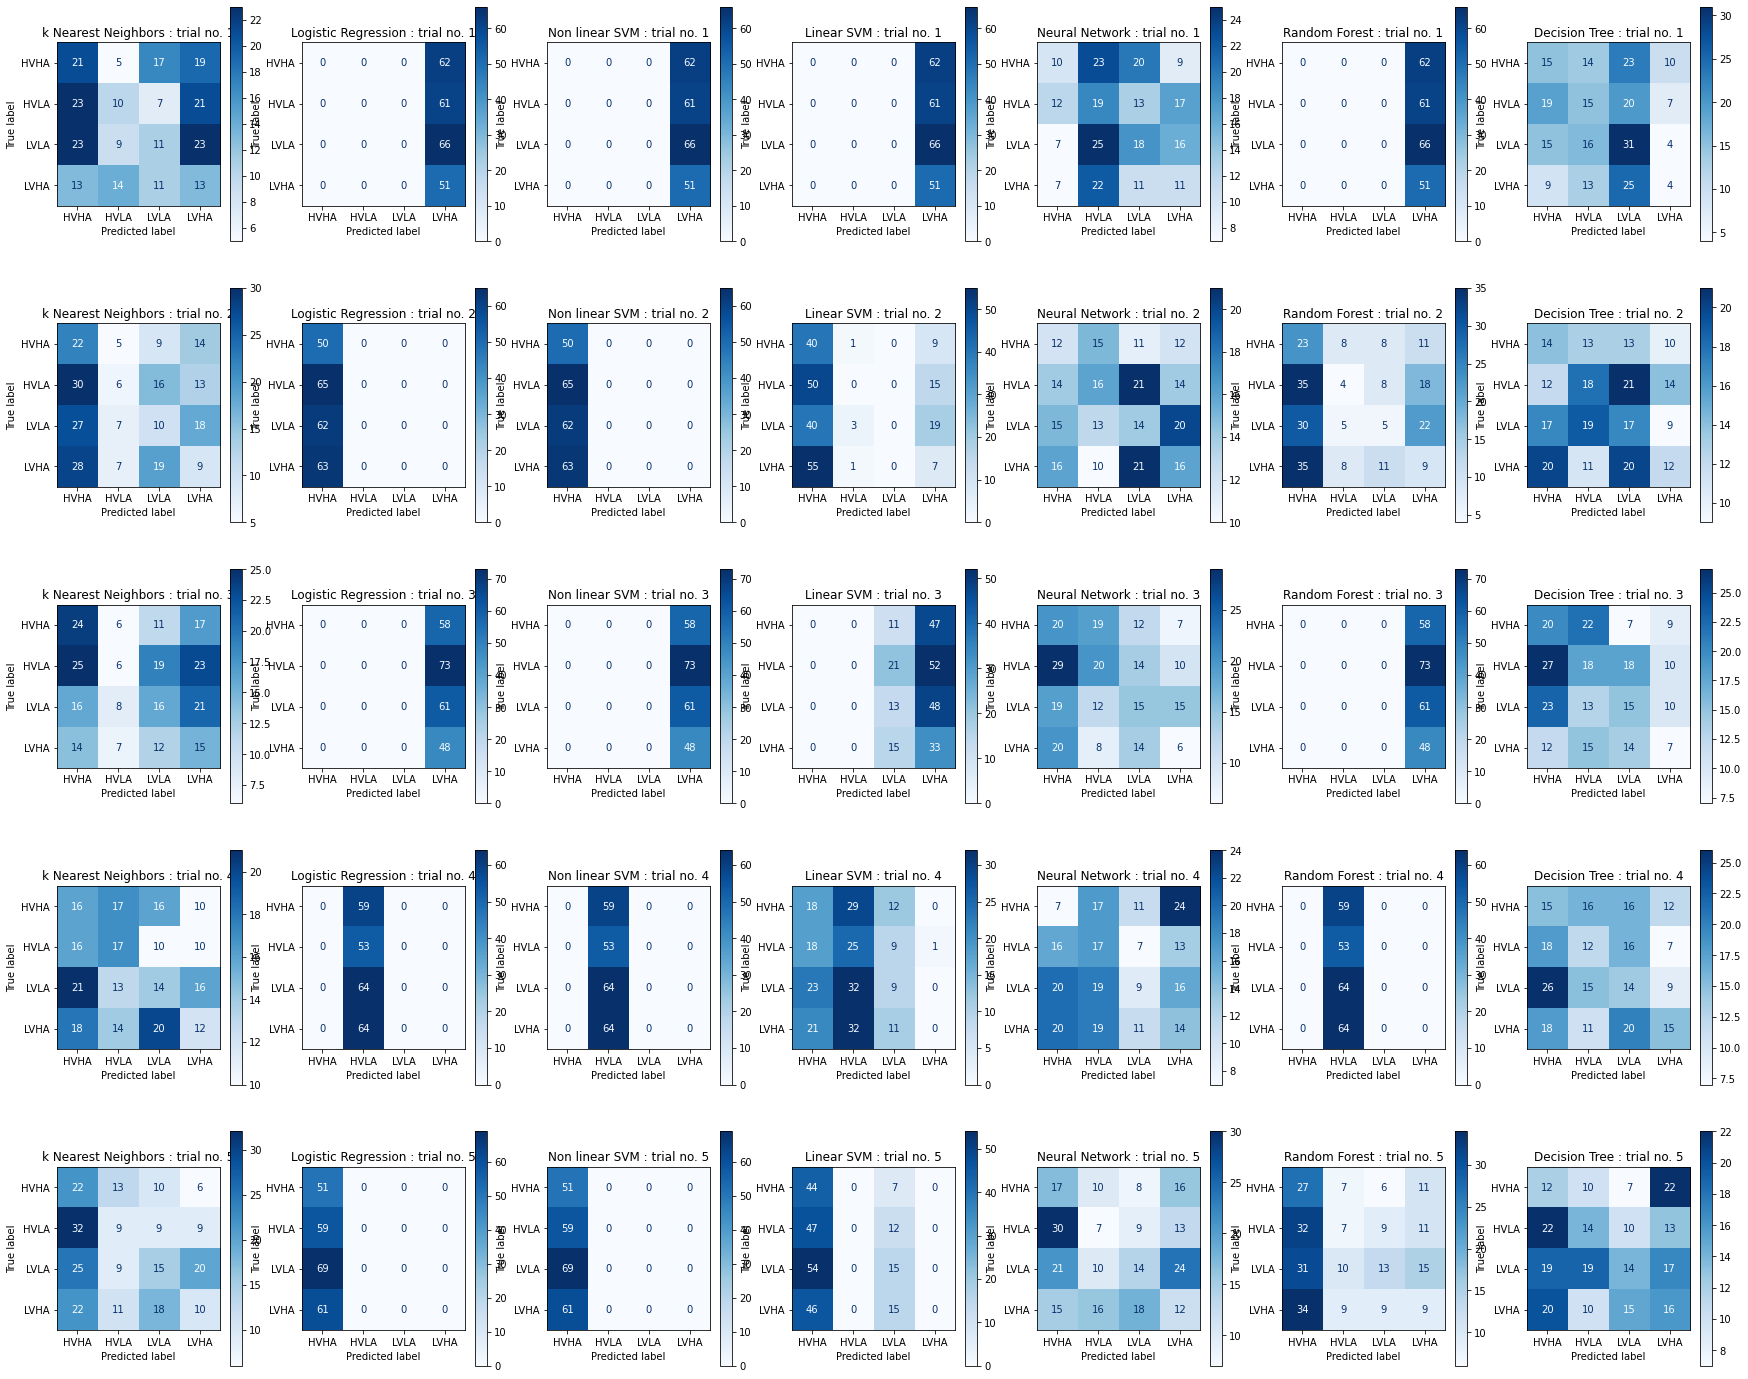

In [ ]:
plot_confusion_matrices(rr_peaks_results)

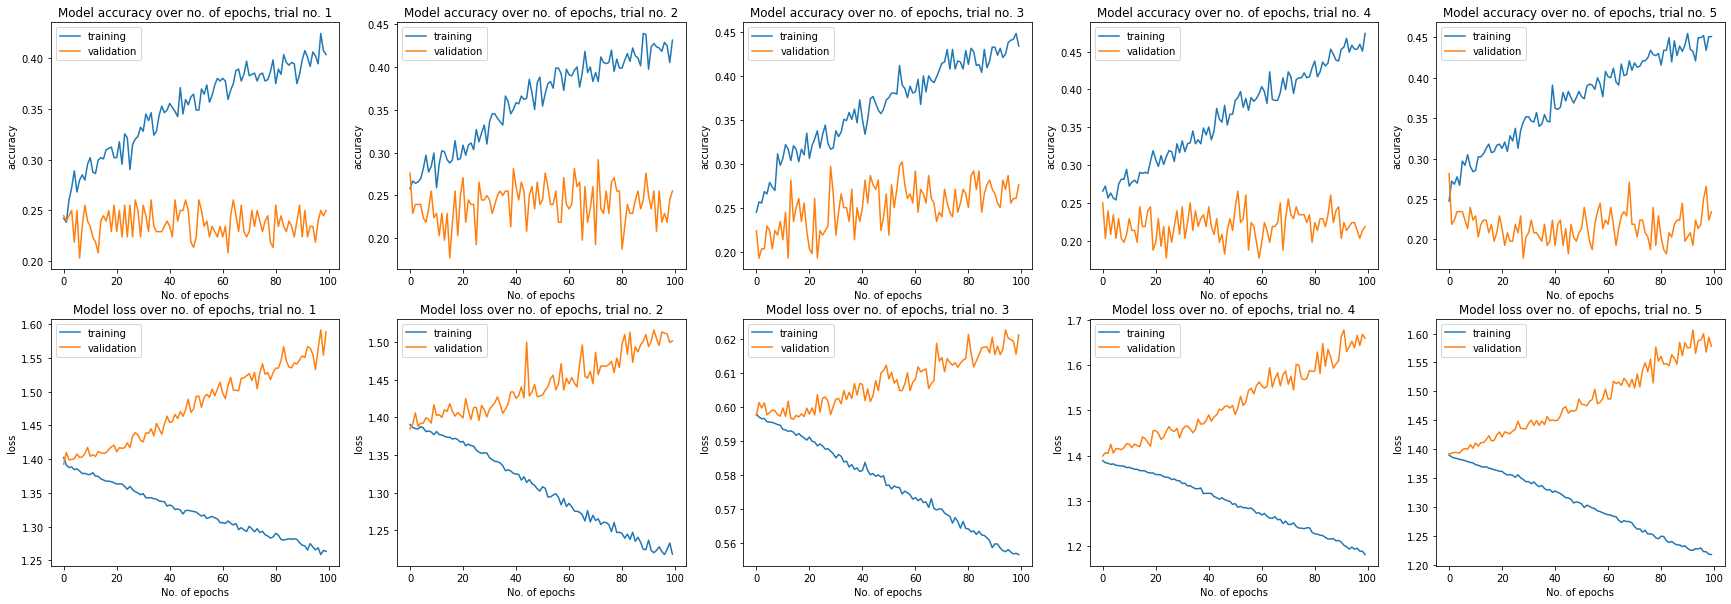

In [ ]:
plot_histories(rr_peaks_results)

### Sliding Window method generated data no. 1

In [ ]:
sliding_window_1st_results = perform_comparison(Paths.SLIDING_WINDOW_1ST_DATA_PATH)

Iteration no. 1
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 2
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 3
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 4
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier

In [ ]:
print_metrics(sliding_window_1st_results)

+------------+--------+--------+--------+--------+--------+------+------+------+
| k Nearest  |        |        |        |        |        |      |      |      |
| Neighbors  |        |        |        |        |        |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|   param    | trial  | trial  | trial  | trial  | trial  | min  | mean | max  |
|            | no. 1  | no. 2  | no. 3  | no. 4  | no. 5  |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
| train_accu | 0.2541 | 0.2458 | 0.2406 | 0.2614 | 0.2604 | 0.24 | 0.25 | 0.26 |
|    racy    |   7    |   3    |   2    |   6    |   2    | 062  |  25  | 146  |
+------------+--------+--------+--------+--------+--------+------+------+------+
| test_accur | 0.2458 | 0.2666 | 0.1833 | 0.2541 | 0.2083 | 0.18 | 0.23 | 0.26 |
|    acy     |   3    |   7    |   3    |   7    |   3    | 333  | 167  | 667  |
+------------+--------+-----

In [ ]:
print_cv_scores(sliding_window_1st_results)

+------------+--------+--------+--------+--------+--------+------+------+------+
| k Nearest  |        |        |        |        |        |      |      |      |
| Neighbors  |        |        |        |        |        |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|   trial    | split  | split  | split  | split  | split  | min  | mean | max  |
|            | no. 1  | no. 2  | no. 3  | no. 4  | no. 5  |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|     1      | 0.2291 | 0.2187 | 0.2552 | 0.2604 | 0.1718 | 0.17 | 0.22 | 0.26 |
|            |   7    |   5    |   1    |   2    |   8    | 188  | 708  | 042  |
+------------+--------+--------+--------+--------+--------+------+------+------+
|     2      | 0.2343 | 0.2031 | 0.1770 | 0.2291 | 0.1666 | 0.16 | 0.20 | 0.23 |
|            |   8    |   2    |   8    |   7    |   7    | 667  | 208  | 438  |
+------------+--------+-----

In [ ]:
print_best_params(sliding_window_1st_results)

+------------------+-----------+-----------+-----------+-----------+-----------+
| k Nearest Neighb |           |           |           |           |           |
|       ors        |           |           |           |           |           |
+------------------+-----------+-----------+-----------+-----------+-----------+
|      param       | trial no. | trial no. | trial no. | trial no. | trial no. |
|                  |     1     |     2     |     3     |     4     |     5     |
+------------------+-----------+-----------+-----------+-----------+-----------+
|    algorithm     |   auto    |   auto    |   auto    |   auto    |   auto    |
+------------------+-----------+-----------+-----------+-----------+-----------+
|   n_neighbors    |     5     |    100    |    100    |    100    |    50     |
+------------------+-----------+-----------+-----------+-----------+-----------+
|        p         |     2     |     1     |     1     |     2     |     1     |
+------------------+--------

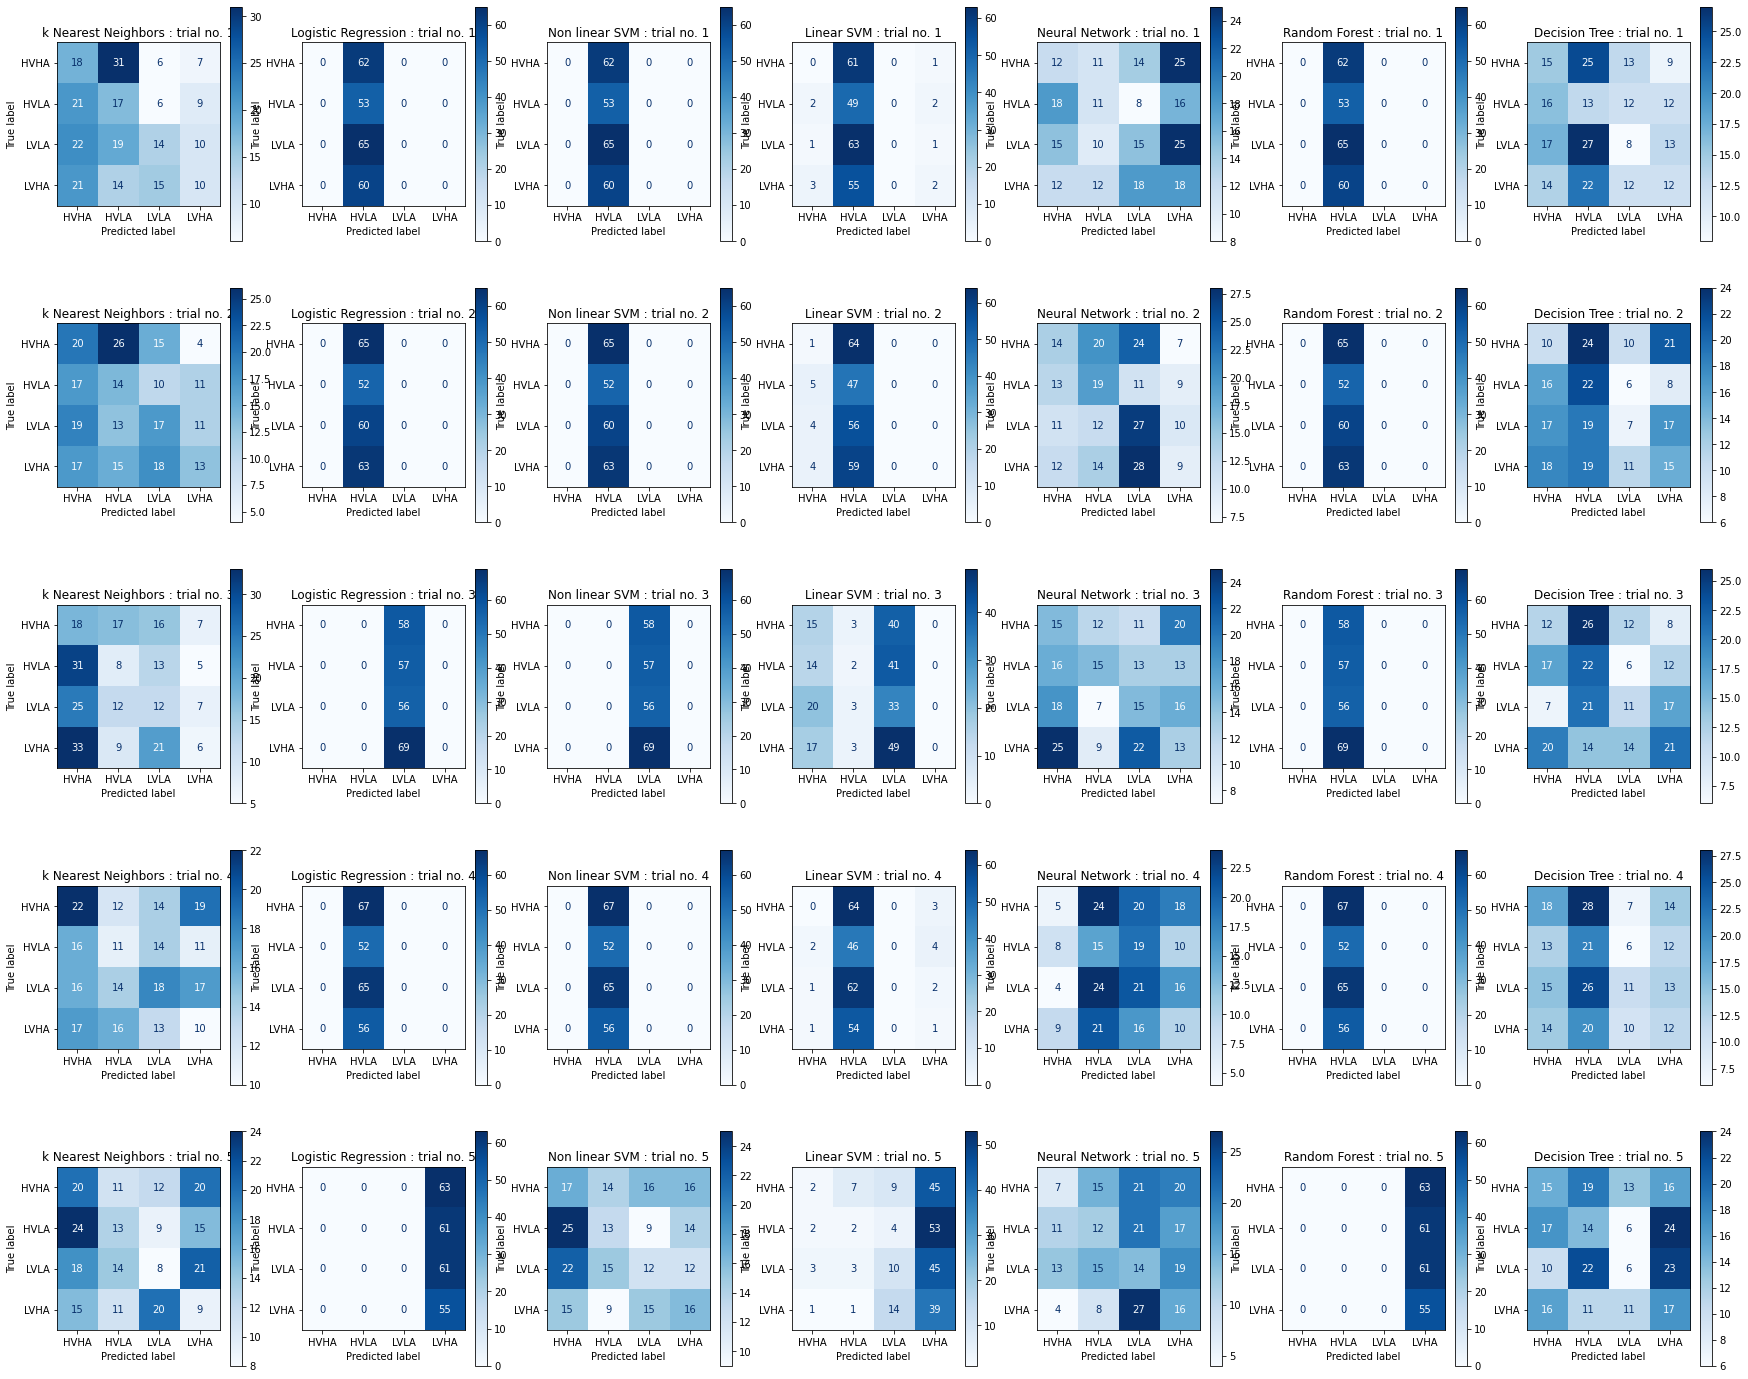

In [ ]:
plot_confusion_matrices(sliding_window_1st_results)

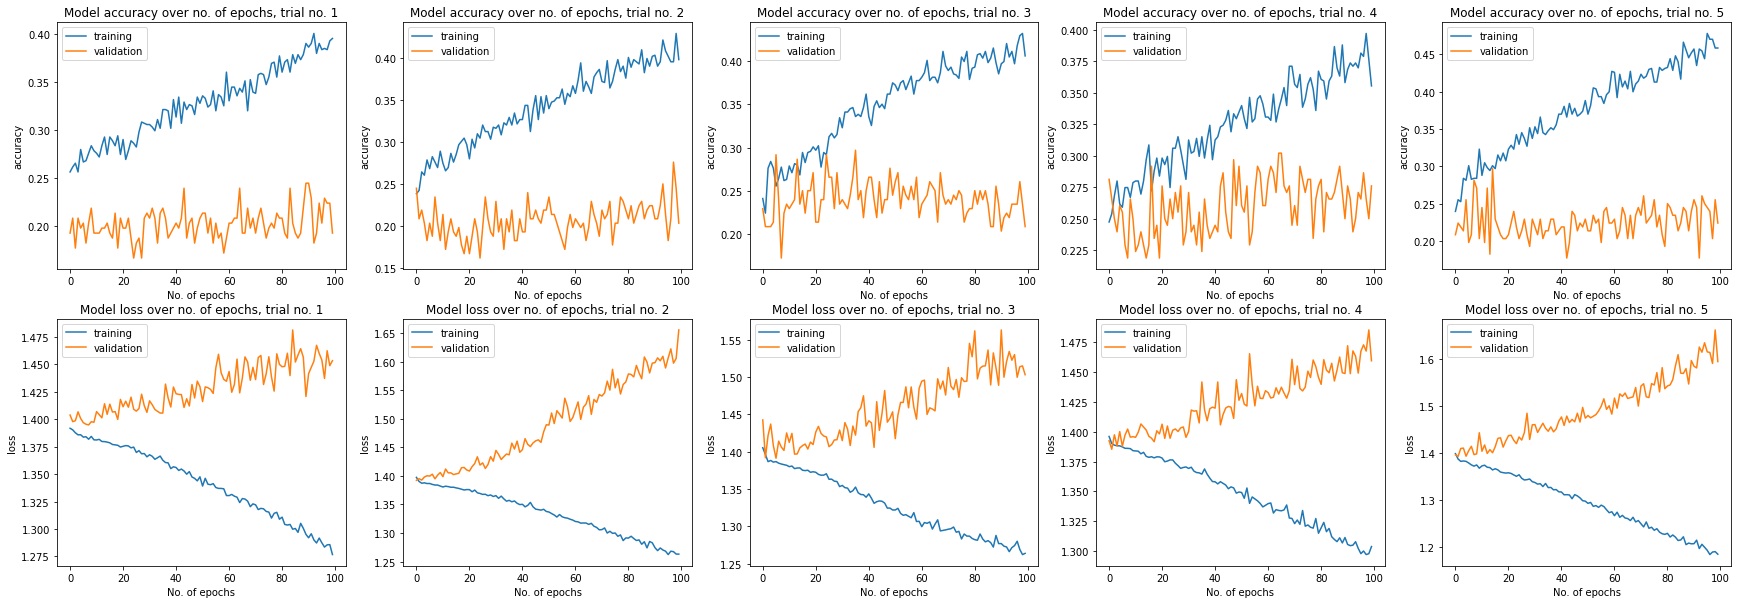

In [ ]:
plot_histories(sliding_window_1st_results)

### Sliding Window method generated data no. 2

In [ ]:
sliding_window_2nd_results = perform_comparison(Paths.SLIDING_WINDOW_2ND_DATA_PATH)

Iteration no. 1
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
rm: cannot remove 'my_tuner': No such file or directory
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 2
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 3
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 4
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Ne

In [ ]:
print_metrics(sliding_window_2nd_results)

+------------+--------+--------+--------+--------+--------+------+------+------+
| k Nearest  |        |        |        |        |        |      |      |      |
| Neighbors  |        |        |        |        |        |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|   param    | trial  | trial  | trial  | trial  | trial  | min  | mean | max  |
|            | no. 1  | no. 2  | no. 3  | no. 4  | no. 5  |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
| train_accu | 0.2604 | 0.2562 | 0.2541 | 0.2625 | 0.2687 | 0.25 | 0.26 | 0.26 |
|    racy    |   2    |   5    |   7    |        |   5    | 417  | 042  | 875  |
+------------+--------+--------+--------+--------+--------+------+------+------+
| test_accur | 0.1708 | 0.2333 | 0.2583 | 0.2041 | 0.2416 | 0.17 | 0.22 | 0.25 |
|    acy     |   3    |   3    |   3    |   7    |   7    | 083  | 167  | 833  |
+------------+--------+-----

In [ ]:
print_cv_scores(sliding_window_2nd_results)

+------------+--------+--------+--------+--------+--------+------+------+------+
| k Nearest  |        |        |        |        |        |      |      |      |
| Neighbors  |        |        |        |        |        |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|   trial    | split  | split  | split  | split  | split  | min  | mean | max  |
|            | no. 1  | no. 2  | no. 3  | no. 4  | no. 5  |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|     1      | 0.1927 | 0.2031 | 0.1822 | 0.2604 | 0.2135 | 0.18 | 0.21 | 0.26 |
|            |   1    |   2    |   9    |   2    |   4    | 229  | 042  | 042  |
+------------+--------+--------+--------+--------+--------+------+------+------+
|     2      | 0.2239 | 0.1979 | 0.2291 | 0.2343 | 0.2656 | 0.19 | 0.23 | 0.26 |
|            |   6    |   2    |   7    |   8    |   2    | 792  | 021  | 562  |
+------------+--------+-----

In [ ]:
print_best_params(sliding_window_2nd_results)

+------------------+-----------+-----------+-----------+-----------+-----------+
| k Nearest Neighb |           |           |           |           |           |
|       ors        |           |           |           |           |           |
+------------------+-----------+-----------+-----------+-----------+-----------+
|      param       | trial no. | trial no. | trial no. | trial no. | trial no. |
|                  |     1     |     2     |     3     |     4     |     5     |
+------------------+-----------+-----------+-----------+-----------+-----------+
|    algorithm     |   auto    |   auto    |   auto    |   auto    |   auto    |
+------------------+-----------+-----------+-----------+-----------+-----------+
|   n_neighbors    |    100    |     5     |     5     |     5     |    100    |
+------------------+-----------+-----------+-----------+-----------+-----------+
|        p         |     1     |     2     |     2     |     2     |     1     |
+------------------+--------

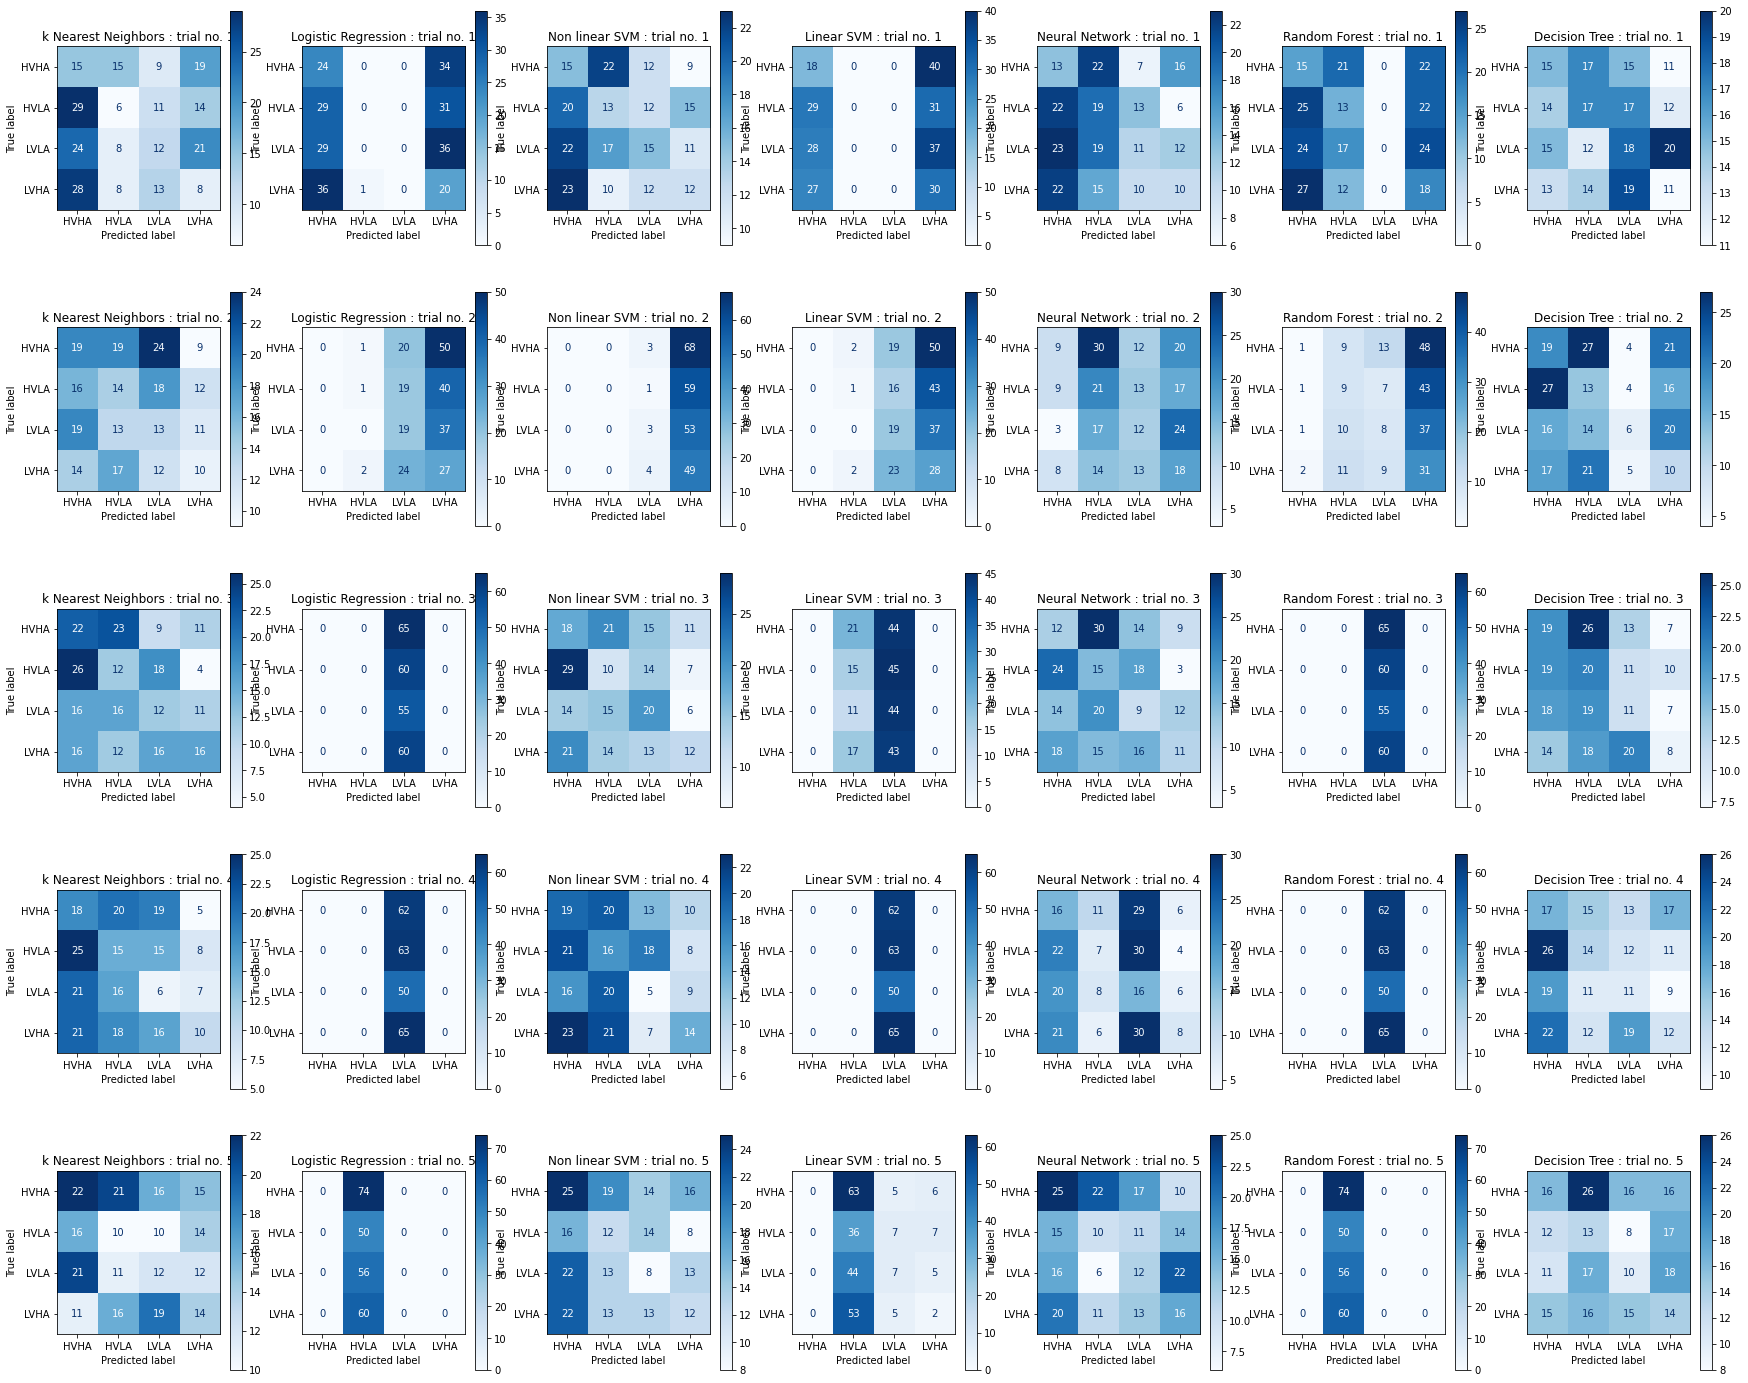

In [ ]:
plot_confusion_matrices(sliding_window_2nd_results)

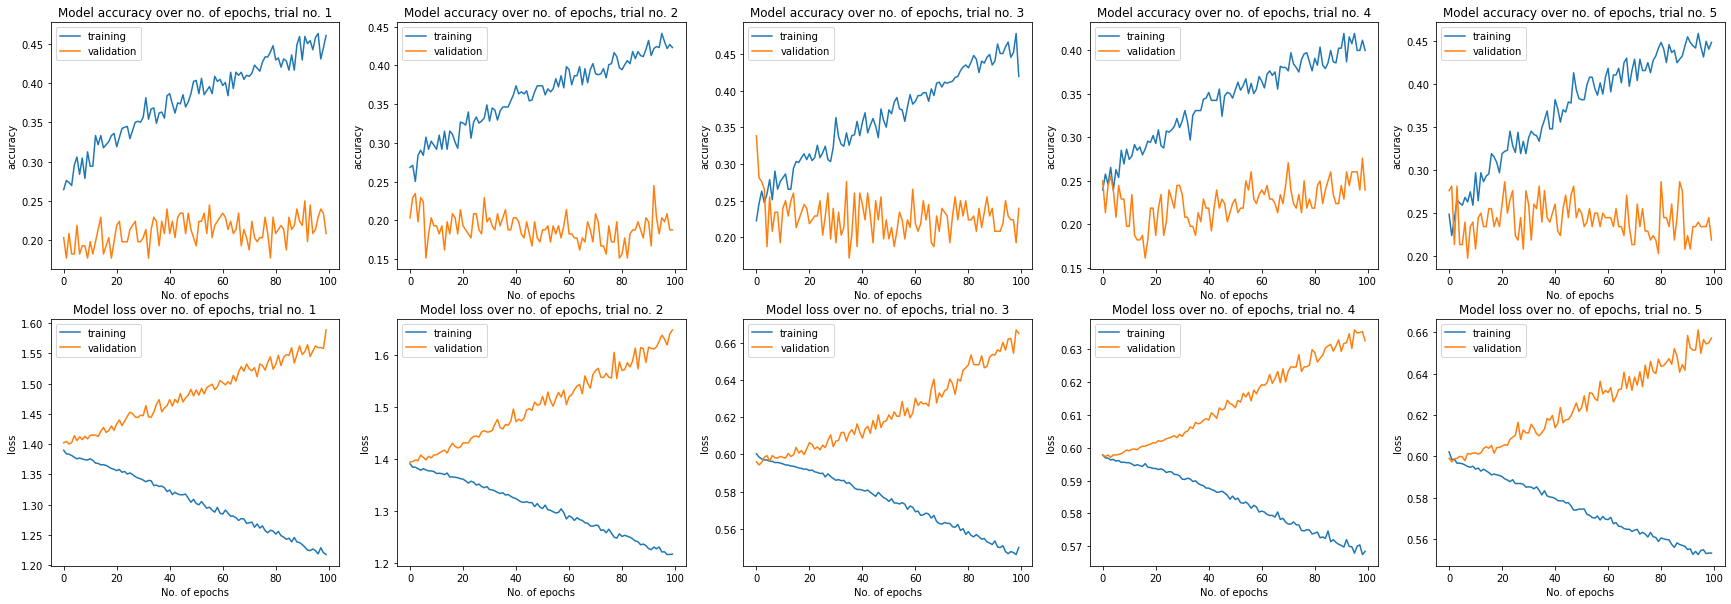

In [ ]:
plot_histories(sliding_window_2nd_results)

### Sliding Window method generated data no. 3

In [ ]:
sliding_window_3rd_results = perform_comparison(Paths.SLIDING_WINDOW_3RD_DATA_PATH)

Iteration no. 1
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 2
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 3
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier: Random Forest
- classifier: Decision Tree
Iteration no. 4
- classifier: k Nearest Neighbors
- classifier: Logistic Regression
- classifier: Non linear SVM
- classifier: Linear SVM
- classifier: Neural Network
INFO:tensorflow:Oracle triggered exit
- classifier

In [ ]:
print_metrics(sliding_window_3rd_results)

+------------+--------+--------+--------+--------+--------+------+------+------+
| k Nearest  |        |        |        |        |        |      |      |      |
| Neighbors  |        |        |        |        |        |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|   param    | trial  | trial  | trial  | trial  | trial  | min  | mean | max  |
|            | no. 1  | no. 2  | no. 3  | no. 4  | no. 5  |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
| train_accu | 0.2552 | 0.2447 | 0.2458 | 0.2510 | 0.2593 | 0.24 | 0.25 | 0.25 |
|    racy    |   1    |   9    |   3    |   4    |   8    | 479  | 125  | 938  |
+------------+--------+--------+--------+--------+--------+------+------+------+
| test_accur | 0.225  | 0.2125 | 0.1833 | 0.2625 | 0.225  | 0.18 | 0.22 | 0.26 |
|    acy     |        |        |   3    |        |        | 333  | 167  |  25  |
+------------+--------+-----

In [ ]:
print_cv_scores(sliding_window_3rd_results)

+------------+--------+--------+--------+--------+--------+------+------+------+
| k Nearest  |        |        |        |        |        |      |      |      |
| Neighbors  |        |        |        |        |        |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|   trial    | split  | split  | split  | split  | split  | min  | mean | max  |
|            | no. 1  | no. 2  | no. 3  | no. 4  | no. 5  |      |      |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|     1      | 0.2291 | 0.2135 | 0.2135 |  0.25  | 0.2031 | 0.20 | 0.22 | 0.25 |
|            |   7    |   4    |   4    |        |   2    | 312  | 188  |      |
+------------+--------+--------+--------+--------+--------+------+------+------+
|     2      | 0.2291 | 0.2031 | 0.2135 | 0.2187 | 0.2395 | 0.20 | 0.22 | 0.23 |
|            |   7    |   2    |   4    |   5    |   8    | 312  | 083  | 958  |
+------------+--------+-----

In [ ]:
print_best_params(sliding_window_3rd_results)

+------------------+-----------+-----------+-----------+-----------+-----------+
| k Nearest Neighb |           |           |           |           |           |
|       ors        |           |           |           |           |           |
+------------------+-----------+-----------+-----------+-----------+-----------+
|      param       | trial no. | trial no. | trial no. | trial no. | trial no. |
|                  |     1     |     2     |     3     |     4     |     5     |
+------------------+-----------+-----------+-----------+-----------+-----------+
|    algorithm     |   auto    |   auto    |   auto    |   auto    |   auto    |
+------------------+-----------+-----------+-----------+-----------+-----------+
|   n_neighbors    |    100    |     5     |    50     |     5     |     5     |
+------------------+-----------+-----------+-----------+-----------+-----------+
|        p         |     2     |     2     |     2     |     1     |     2     |
+------------------+--------

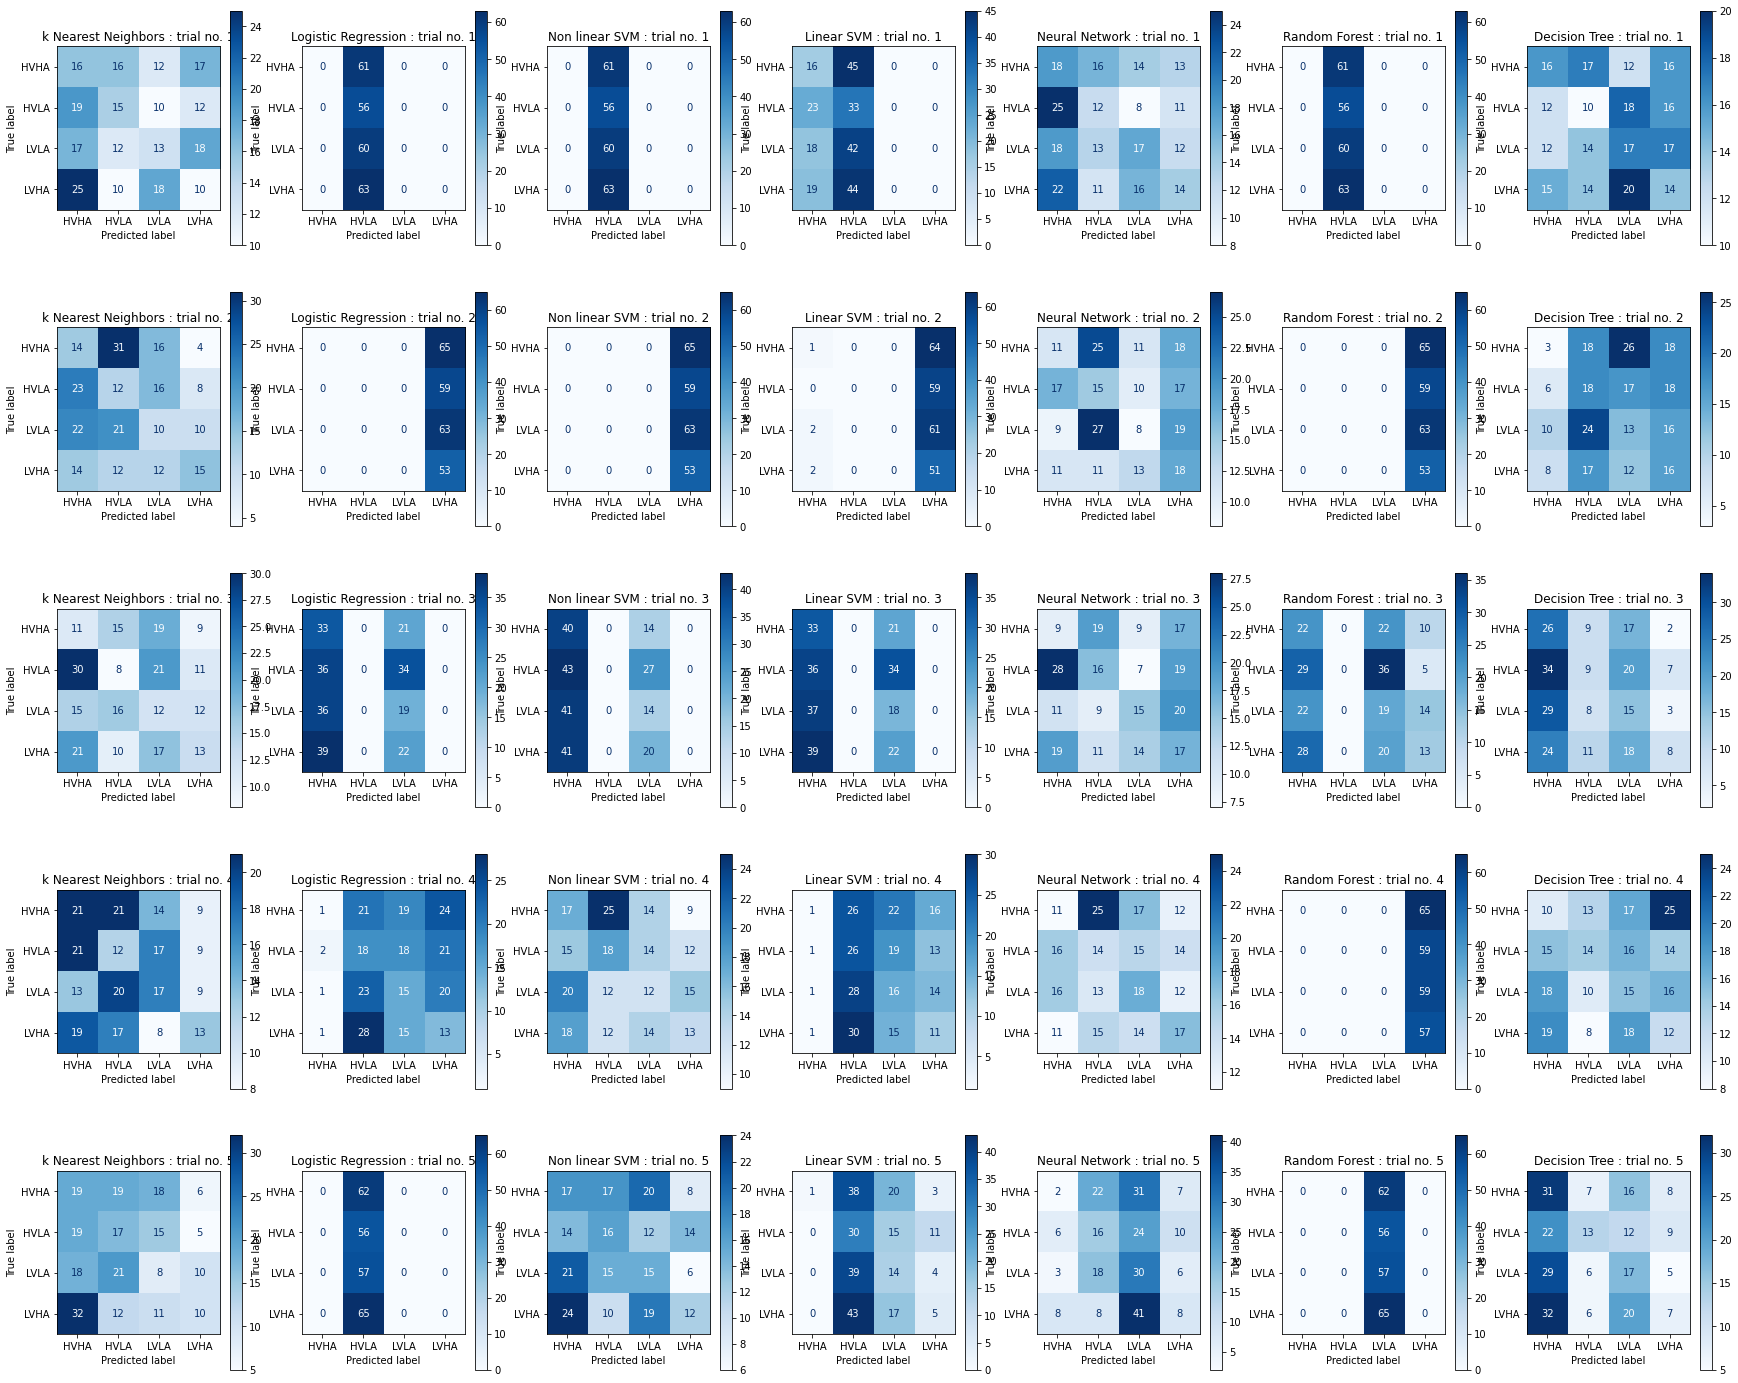

In [ ]:
plot_confusion_matrices(sliding_window_3rd_results)

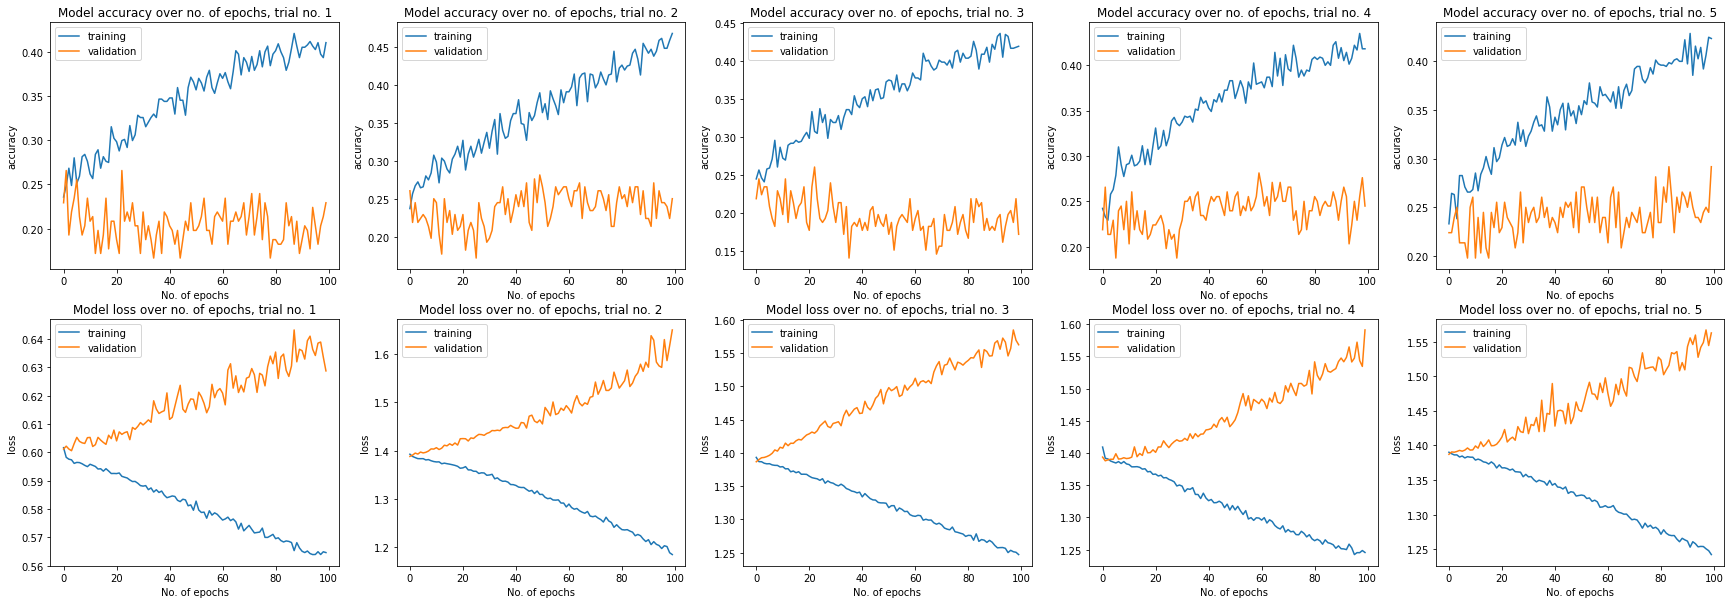

In [ ]:
plot_histories(sliding_window_3rd_results)